---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 3. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

Use this first cell to import the necessary libraries.

In [ ]:
# create more cells if necessary



# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc);
2.	create the dataloader to load the data.



In [33]:
# Import required libraries
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Path to the dataset file
DATA_PATH = "assignment3-ner_dataset.txt"

# Function to read the dataset from a text file
def read_data(filepath):
    """
    Reads the NER dataset from a text file where each line contains a word and its tag,
    separated by a space. Sentences are separated by blank lines.
    
    Args:
        filepath (str): Path to the dataset file.
    
    Returns:
        sentences (list): List of sentences, where each sentence is a list of words.
        tags (list): List of tag sequences, where each sequence is a list of tags.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        sentences = []
        tags = []
        words = []
        labels = []
        for line in f:
            line = line.strip()
            if line == "":
                if words:
                    sentences.append(words)
                    tags.append(labels)
                    words = []
                    labels = []
            else:
                word, tag = line.split()
                words.append(word)
                labels.append(tag)
        # Add the last sentence if it exists
        if words:
            sentences.append(words)
            tags.append(labels)
    return sentences, tags

# Function to build vocabularies for words and tags
def build_vocab(sentences, tags):
    """
    Creates vocabularies mapping words and tags to indices, including special tokens
    <PAD> for padding and <UNK> for unknown words.
    
    Args:
        sentences (list): List of sentences (each a list of words).
        tags (list): List of tag sequences (each a list of tags).
    
    Returns:
        word2idx (dict): Dictionary mapping words to indices.
        tag2idx (dict): Dictionary mapping tags to indices.
        idx2tag (dict): Dictionary mapping indices to tags.
    """
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    tag2idx = {'<PAD>': 0}
    
    # Build word vocabulary
    for sent in sentences:
        for word in sent:
            if word not in word2idx:
                word2idx[word] = len(word2idx)
    
    # Build tag vocabulary
    for tag_seq in tags:
        for tag in tag_seq:
            if tag not in tag2idx:
                tag2idx[tag] = len(tag2idx)
    
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    return word2idx, tag2idx, idx2tag

# Custom Dataset class for NER
class NERDataset(Dataset):
    """
    A PyTorch Dataset class for NER data, converting words and tags to indices
    and padding sequences to a fixed length.
    """
    def __init__(self, sentences, tags, word2idx, tag2idx, max_len):
        """
        Initializes the dataset.
        
        Args:
            sentences (list): List of sentences (each a list of words).
            tags (list): List of tag sequences (each a list of tags).
            word2idx (dict): Dictionary mapping words to indices.
            tag2idx (dict): Dictionary mapping tags to indices.
            max_len (int): Maximum sentence length for padding.
        """
        self.data = []
        for s, t in zip(sentences, tags):
            # Convert words to indices, using <UNK> for unknown words
            word_ids = [word2idx.get(word, word2idx['<UNK>']) for word in s]
            # Convert tags to indices
            tag_ids = [tag2idx[tag] for tag in t]
            
            # Pad sequences to max_len
            while len(word_ids) < max_len:
                word_ids.append(word2idx['<PAD>'])
                tag_ids.append(tag2idx['<PAD>'])
            
            self.data.append((torch.tensor(word_ids), torch.tensor(tag_ids)))
    
    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Returns a sample from the dataset at the given index.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            tuple: (word_ids, tag_ids) as PyTorch tensors.
        """
        return self.data[idx]

# Read the dataset
sentences, tags = read_data(DATA_PATH)

# Build vocabularies
word2idx, tag2idx, idx2tag = build_vocab(sentences, tags)

# Compute maximum sentence length for padding
MAX_LEN = max(len(s) for s in sentences)

# Split dataset into train (70%), validation (15%), and test (15%)
# First, split into train+val (85%) and test (15%)
train_val_sents, test_sents, train_val_tags, test_tags = train_test_split(
    sentences, tags, test_size=0.15, random_state=42
)

# Then, split train+val into train (70/85 ≈ 82.35%) and val (15/85 ≈ 17.65%)
train_sents, val_sents, train_tags, val_tags = train_test_split(
    train_val_sents, train_val_tags, test_size=0.1765, random_state=42
)

# Verify split sizes
print(f"Total sentences: {len(sentences)}")
print(f"Train set: {len(train_sents)} sentences ({len(train_sents)/len(sentences)*100:.1f}%)")
print(f"Validation set: {len(val_sents)} sentences ({len(val_sents)/len(sentences)*100:.1f}%)")
print(f"Test set: {len(test_sents)} sentences ({len(test_sents)/len(sentences)*100:.1f}%)")

# Create datasets
train_dataset = NERDataset(train_sents, train_tags, word2idx, tag2idx, MAX_LEN)
val_dataset = NERDataset(val_sents, val_tags, word2idx, tag2idx, MAX_LEN)
test_dataset = NERDataset(test_sents, test_tags, word2idx, tag2idx, MAX_LEN)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total sentences: 1696
Train set: 1186 sentences (69.9%)
Validation set: 255 sentences (15.0%)
Test set: 255 sentences (15.0%)


In [ ]:
# create more cells if necessary



---

# 2. **Neural Networks**

Here, you need to:

1.	create a Recurrent Neural Network (RNN) (such as RNN, GRU, LSTM) to tackle the problem;
2.	create a Transformer Network to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train the models;
5.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.

Training LSTM Model...
Epoch 1/20: Train Loss: 0.9666, Train Acc: 0.7855, Val Loss: 0.6813, Val Acc: 0.8255
Epoch 2/20: Train Loss: 0.6079, Train Acc: 0.8374, Val Loss: 0.6281, Val Acc: 0.8255
Epoch 3/20: Train Loss: 0.5460, Train Acc: 0.8379, Val Loss: 0.5800, Val Acc: 0.8266
Epoch 4/20: Train Loss: 0.4719, Train Acc: 0.8464, Val Loss: 0.5406, Val Acc: 0.8314
Epoch 5/20: Train Loss: 0.4127, Train Acc: 0.8663, Val Loss: 0.5197, Val Acc: 0.8367
Epoch 6/20: Train Loss: 0.3617, Train Acc: 0.8841, Val Loss: 0.4880, Val Acc: 0.8426
Epoch 7/20: Train Loss: 0.2894, Train Acc: 0.9045, Val Loss: 0.4912, Val Acc: 0.8501
Epoch 8/20: Train Loss: 0.2447, Train Acc: 0.9205, Val Loss: 0.4742, Val Acc: 0.8544
Epoch 9/20: Train Loss: 0.1995, Train Acc: 0.9369, Val Loss: 0.4591, Val Acc: 0.8573
Epoch 10/20: Train Loss: 0.1587, Train Acc: 0.9505, Val Loss: 0.4678, Val Acc: 0.8675
Epoch 11/20: Train Loss: 0.1337, Train Acc: 0.9604, Val Loss: 0.4708, Val Acc: 0.8609
Epoch 12/20: Train Loss: 0.0990, Train A

/Users/jiwon/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch 1/20: Train Loss: 0.7117, Train Acc: 0.8140, Val Loss: 0.6955, Val Acc: 0.8255
Epoch 2/20: Train Loss: 0.6156, Train Acc: 0.8374, Val Loss: 0.6578, Val Acc: 0.8255
Epoch 3/20: Train Loss: 0.5542, Train Acc: 0.8382, Val Loss: 0.5968, Val Acc: 0.8264
Epoch 4/20: Train Loss: 0.4848, Train Acc: 0.8509, Val Loss: 0.5693, Val Acc: 0.8261
Epoch 5/20: Train Loss: 0.3956, Train Acc: 0.8733, Val Loss: 0.5047, Val Acc: 0.8483
Epoch 6/20: Train Loss: 0.3133, Train Acc: 0.8989, Val Loss: 0.5032, Val Acc: 0.8526
Epoch 7/20: Train Loss: 0.2390, Train Acc: 0.9219, Val Loss: 0.5202, Val Acc: 0.8551
Epoch 8/20: Train Loss: 0.1880, Train Acc: 0.9409, Val Loss: 0.6072, Val Acc: 0.8602
Epoch 9/20: Train Loss: 0.1613, Train Acc: 0.9455, Val Loss: 0.5720, Val Acc: 0.8648
Epoch 10/20: Train Loss: 0.1132, Train Acc: 0.9631, Val Loss: 0.5685, Val Acc: 0.8593
Epoch 11/20: Train Loss: 0.0899, Train Acc: 0.9733, Val Loss: 0.6231, Val Acc: 0.8634
Epoch 12/20: Train Loss: 0.0854, Train Acc: 0.9721, Val Loss: 0

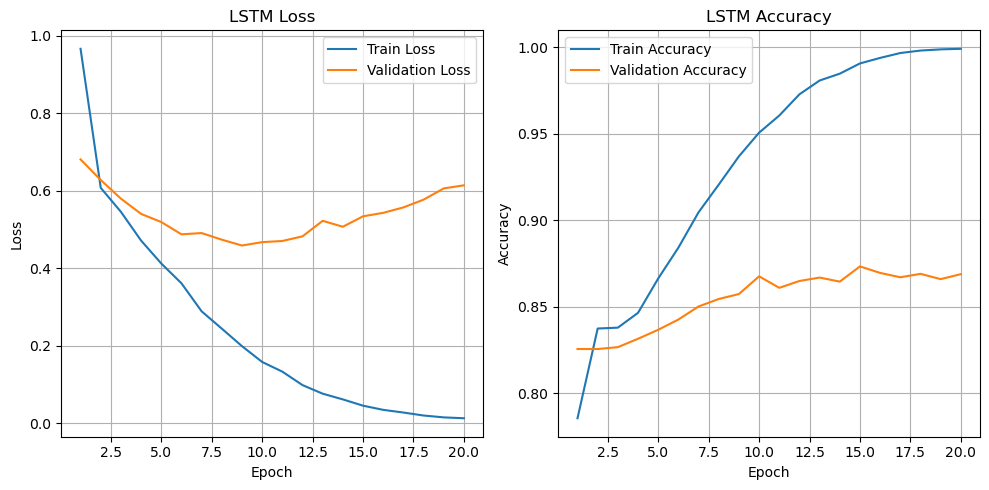

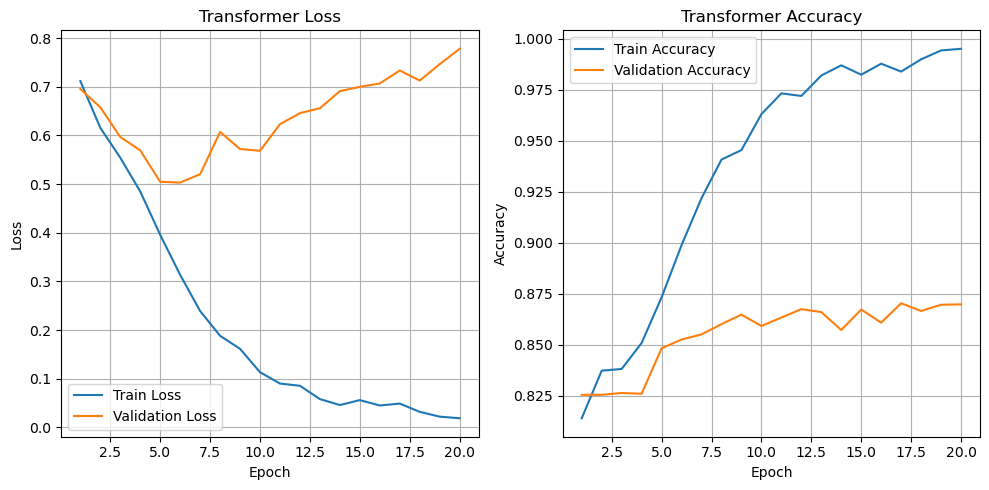

In [38]:
# Import additional required libraries
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# LSTM-based NER model
class LSTMNER(nn.Module):
    """
    A bidirectional LSTM model for Named Entity Recognition.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size):
        """
        Initializes the LSTM model.
        
        Args:
            vocab_size (int): Size of the word vocabulary.
            embedding_dim (int): Dimension of word embeddings.
            hidden_dim (int): Dimension of LSTM hidden states.
            tagset_size (int): Number of unique tags.
        """
        super(LSTMNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, tagset_size)  # *2 for bidirectional
    
    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, tagset_size).
        """
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim * 2)
        out = self.fc(lstm_out)  # (batch_size, seq_len, tagset_size)
        return out

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    """
    Adds positional encoding to the input embeddings for Transformer.
    """
    def __init__(self, d_model, max_len=5000):
        """
        Initializes positional encoding.
        
        Args:
            d_model (int): Dimension of the embeddings.
            max_len (int): Maximum sequence length.
        """
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Adds positional encoding to the input.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model).
        
        Returns:
            torch.Tensor: Input with positional encoding added.
        """
        x = x + self.pe[:, :x.size(1), :]
        return x

# Transformer-based NER model
class TransformerNER(nn.Module):
    """
    A Transformer encoder model for Named Entity Recognition.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_heads, num_layers, tagset_size):
        """
        Initializes the Transformer model.
        
        Args:
            vocab_size (int): Size of the word vocabulary.
            embedding_dim (int): Dimension of word embeddings.
            hidden_dim (int): Dimension of feedforward network.
            num_heads (int): Number of attention heads.
            num_layers (int): Number of Transformer encoder layers.
            tagset_size (int): Number of unique tags.
        """
        super(TransformerNER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len=MAX_LEN)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, tagset_size)
    
    def forward(self, x):
        """
        Forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len).
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, seq_len, tagset_size).
        """
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.pos_encoder(embedded)
        mask = (x == 0)  # Padding mask (True for <PAD> tokens)
        transformer_out = self.transformer_encoder(embedded, src_key_padding_mask=mask)
        out = self.fc(transformer_out)  # (batch_size, seq_len, tagset_size)
        return out

# Function to calculate accuracy
def calculate_accuracy(preds, targets, pad_idx=0):
    """
    Calculates accuracy, ignoring padding tokens.
    
    Args:
        preds (torch.Tensor): Predicted tags (batch_size, seq_len).
        targets (torch.Tensor): True tags (batch_size, seq_len).
        pad_idx (int): Index of padding token.
    
    Returns:
        float: Accuracy score.
    """
    mask = (targets != pad_idx)
    correct = (preds[mask] == targets[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Trains the model and tracks loss and accuracy.
    
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): Training data loader.
        val_loader (DataLoader): Validation data loader.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to run the model on.
    
    Returns:
        dict: History of training and validation metrics.
    """
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for words, tags in train_loader:
            words, tags = words.to(device), tags.to(device)
            optimizer.zero_grad()
            outputs = model(words)  # (batch_size, seq_len, tagset_size)
            outputs = outputs.view(-1, outputs.shape[-1])  # (batch_size * seq_len, tagset_size)
            tags = tags.view(-1)  # (batch_size * seq_len)
            loss = criterion(outputs, tags)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            mask = (tags != tag2idx['<PAD>'])
            train_correct += (preds[mask] == tags[mask]).sum().item()
            train_total += mask.sum().item()
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0.0
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for words, tags in val_loader:
                words, tags = words.to(device), tags.to(device)
                outputs = model(words)
                outputs = outputs.view(-1, outputs.shape[-1])
                tags = tags.view(-1)
                loss = criterion(outputs, tags)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                mask = (tags != tag2idx['<PAD>'])
                val_correct += (preds[mask] == tags[mask]).sum().item()
                val_total += mask.sum().item()
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0.0
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history

# Plotting function
def plot_metrics(history, model_name):
    """
    Plots training and validation loss and accuracy.
    
    Args:
        history (dict): Dictionary containing training and validation metrics.
        model_name (str): Name of the model for plot titles.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

# Initialize LSTM model
lstm_model = LSTMNER(
    vocab_size=len(word2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    tagset_size=len(tag2idx)
).to(device)

# Initialize Transformer model
transformer_model = TransformerNER(
    vocab_size=len(word2idx),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM * 4,  # Feedforward dimension
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    tagset_size=len(tag2idx)
).to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss(ignore_index=tag2idx['<PAD>'])
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE)

# Train LSTM model
print("Training LSTM Model...")
lstm_history = train_model(
    lstm_model, train_loader, val_loader, criterion, lstm_optimizer, NUM_EPOCHS, device
)

# Train Transformer model
print("Training Transformer Model...")
transformer_history = train_model(
    transformer_model, train_loader, val_loader, criterion, transformer_optimizer, NUM_EPOCHS, device
)

# Plot metrics
plot_metrics(lstm_history, "LSTM")
plot_metrics(transformer_history, "Transformer")

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best ones you obtained in the above stage).


Evaluating LSTM Model on Test Set...
Test Loss: 0.6046
Accuracy: 0.8720
Precision (weighted): 0.8560
Recall (weighted): 0.8720
F1 Score (weighted): 0.8617


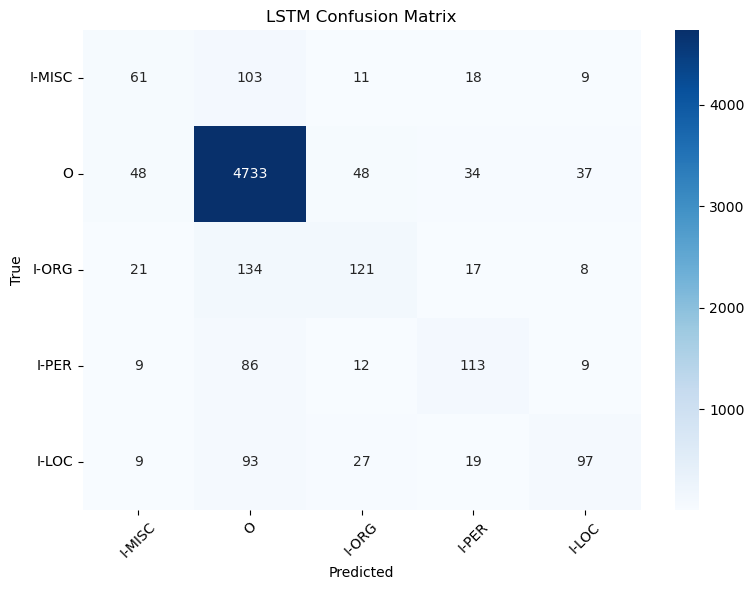

In [40]:
# Import additional required libraries for evaluation
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, criterion, device, idx2tag):
    """
    Evaluates the model on the test set using multiple metrics and computes confusion matrix.
    
    Args:
        model (nn.Module): The trained neural network model.
        test_loader (DataLoader): Test data loader.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to run the model on.
        idx2tag (dict): Dictionary mapping tag indices to tag names.
    
    Returns:
        dict: Dictionary containing test loss, accuracy, precision, recall, F1 score.
        np.ndarray: Confusion matrix.
        list: List of tag names (excluding <PAD>).
    """
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for words, tags in test_loader:
            words, tags = words.to(device), tags.to(device)
            outputs = model(words)  # (batch_size, seq_len, tagset_size)
            outputs = outputs.view(-1, outputs.shape[-1])  # (batch_size * seq_len, tagset_size)
            tags_flat = tags.view(-1)  # (batch_size * seq_len)
            loss = criterion(outputs, tags_flat)
            test_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            mask = (tags_flat != tag2idx['<PAD>'])
            all_preds.extend(preds[mask].cpu().numpy())
            all_targets.extend(tags_flat[mask].cpu().numpy())
    
    # Calculate metrics
    test_loss /= len(test_loader)
    accuracy = calculate_accuracy(torch.tensor(all_preds), torch.tensor(all_targets))
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # Compute confusion matrix
    labels = [i for i, tag in idx2tag.items() if tag != '<PAD>']
    tag_names = [idx2tag[i] for i in labels]
    cm = confusion_matrix(all_targets, all_preds, labels=labels)
    
    metrics = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return metrics, cm, tag_names

# Function to plot confusion matrix
def plot_confusion_matrix(cm, tag_names, title='Confusion Matrix'):
    """
    Plots the confusion matrix as a heatmap.
    
    Args:
        cm (np.ndarray): Confusion matrix.
        tag_names (list): List of tag names.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=tag_names, yticklabels=tag_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Evaluate the best model (LSTM) on the test set
print("Evaluating LSTM Model on Test Set...")
metrics, cm, tag_names = evaluate_model(lstm_model, test_loader, criterion, device, idx2tag)

# Print evaluation results
print(f"Test Loss: {metrics['test_loss']:.4f}")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision (weighted): {metrics['precision']:.4f}")
print(f"Recall (weighted): {metrics['recall']:.4f}")
print(f"F1 Score (weighted): {metrics['f1']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(cm, tag_names, title='LSTM Confusion Matrix')